In [24]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data.csv')
df["Квартиры₽/м²"] = df["Квартиры₽/м²"].str.replace(" ", "", regex=True)

data = df['Квартиры₽/м²']

data = data.astype(int)  # Преобразование цен в int

In [3]:
train_size = int(len(data) * 0.9)
train, test = data[:train_size], data[train_size:]

In [4]:
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.forecast(steps=len(test))

In [5]:
mae_arima = mean_absolute_error(test, predictions_arima)
rmse_arima = np.sqrt(mean_squared_error(test, predictions_arima))
print(f'ARIMA: MAE={mae_arima:.2f}, RMSE={rmse_arima:.2f}')

ARIMA: MAE=22849.26, RMSE=23636.93


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.values.reshape(-1,1))

In [7]:
def create_dataset(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
look_back = 10
X_train, y_train = create_dataset(data_scaled[:train_size], look_back)
X_test, y_test = create_dataset(data_scaled[train_size:], look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
model_1 = keras.Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
])
model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0351
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0036
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030
Epoch 13/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 14/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 15/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017


In [13]:
predictions_lstm = model_1.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
predictions_lstm = predictions_lstm.astype(int)  # Преобразование предсказаний в

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


In [14]:
mae_lstm = mean_absolute_error(test[look_back+1:], predictions_lstm)
rmse_lstm = np.sqrt(mean_squared_error(test[look_back+1:], predictions_lstm))
print(f'LSTM: MAE={mae_lstm:.2f}, RMSE={rmse_lstm:.2f}')

LSTM: MAE=9628.29, RMSE=11311.56


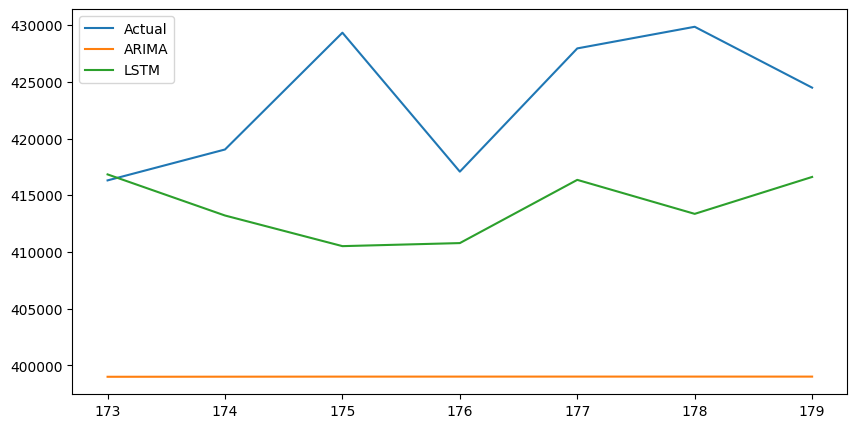

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(test.index[look_back+1:], test[look_back+1:], label='Actual')
plt.plot(test.index[look_back+1:], predictions_arima[11::], label='ARIMA')
plt.plot(test.index[look_back+1:], predictions_lstm, label='LSTM')
plt.legend()
plt.show()